# Project: In-depth Data Wrangling.
- Steps involved in the project include:
<ol>
  <li><a href='#intro'>Introduction</a></li>
  <li><a href='#wrangle'>Data Wrangling</a></li>
  <li><a href='#eda'>Exploratory Data Analysis</a></li>

# <a id='intro'>Introduction</a>

- The project at hand involves using a csv dataset twitter-archive-enhanced, web scrapping from a provided url to obtain a tsv file image-predictions and finally using twitter api to obtain data from a twitter account called WeRateDogs. After gathering all the datasets, I have to Assess all three dataset and Clean all the data issues obtained then merge the dataset and upload the dataset into SQLite. After,Assess the data from SQLite and Assess it the come up with visualisations.

# <a id='wrangle'>Data Wrangling</a>

- There are three steps in Data Wrangling:
 <ol>
    <li><a href='#gather'>Gathering</a></li>
    <li><a href='#assess'>Assessing</a></li>
    <li><a href='clean'>Cleaning</a></li>
 </ol>
        

## <a id='gather'>Gathering</a>

In [1]:
#Import all necessary libraries.
import pandas as pd
import numpy as np
import requests
import os
import tweepy
from tweepy import TweepyException
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#Load the dataset into a dataframe
RateDogs_df = pd.read_csv('twitter-archive-enhanced.csv')

In [3]:
#Assess if it is properly loaded.
RateDogs_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [4]:
#Extract data from a website 
folder_name = 'image predictions'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    
url = ' https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

with open(os.path.join(folder_name,url.split('/')[-1]),mode = 'wb') as file:
        file.write(response.content)

In [5]:
#Load the extracted data into a dataframe
images_df = pd.read_csv('image predictions/image-predictions.tsv',sep='\t')
images_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [6]:
#Get Authentification for Twitter API
#Running my tweeter keys from another notebook
%run ./keys.ipynb

#Authentification
auth = tweepy.OAuthHandler(api_key,api_key_secret)
auth.set_access_token(access_token,access_token_secret)

api = tweepy.API(auth)


In [7]:
#Extract the json text into a textfile
tweet_ids = RateDogs_df['tweet_id'].values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepyException as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

1: 892420643555336193
Success
2: 892177421306343426
Success
3: 891815181378084864
Success
4: 891689557279858688
Success
5: 891327558926688256
Success
6: 891087950875897856
Success
7: 890971913173991426
Success
8: 890729181411237888
Success
9: 890609185150312448
Success
10: 890240255349198849
Success
11: 890006608113172480
Success
12: 889880896479866881
Success
13: 889665388333682689
Success
14: 889638837579907072
Success
15: 889531135344209921
Success
16: 889278841981685760
Success
17: 888917238123831296
Success
18: 888804989199671297
Success
19: 888554962724278272
Success
20: 888202515573088257
Fail
21: 888078434458587136
Success
22: 887705289381826560
Success
23: 887517139158093824
Success
24: 887473957103951883
Success
25: 887343217045368832
Success
26: 887101392804085760
Success
27: 886983233522544640
Success
28: 886736880519319552
Success
29: 886680336477933568
Success
30: 886366144734445568
Success
31: 886267009285017600
Success
32: 886258384151887873
Success
33: 8860541600590725

In [7]:
#Load the textfile into a dataframe
data = []
with open("tweet_json.txt",'r') as file:
    for line in file:
        tweets = json.loads(line)
        data.append(tweets)
        tweets_df = pd.DataFrame(data,columns=['id','retweet_count','favorite_count','full_text'])
        

In [8]:
#Assess the dataframe structure
tweets_df

,id,retweet_count,favorite_count,full_text
0,892420643555336193,7009,33812,This is Phineas. He's a mystical boy. Only eve...
1,892177421306343426,5301,29330,This is Tilly. She's just checking pup on you....
2,891815181378084864,3481,22050,This is Archie. He is a rare Norwegian Pouncin...
3,891689557279858688,7225,36937,This is Darla. She commenced a snooze mid meal...
4,891327558926688256,7760,35310,This is Franklin. He would like you to stop ca...
...,...,...,...,...
2322,666049248165822465,37,89,Here we have a 1949 1st generation vulpix. Enj...
2323,666044226329800704,115,247,This is a purebred Piers Morgan. Loves to Netf...
2324,666033412701032449,36,100,Here is a very happy pup. Big fan of well-main...
2325,666029285002620928,39,112,This is a western brown Mitsubishi terrier. Up...


## <a id='assess'>Assessing</a>

In [9]:
RateDogs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [10]:
RateDogs_df.isnull().sum()

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

In [11]:
RateDogs_df.duplicated().sum()

0

In [12]:
RateDogs_df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [13]:
images_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [14]:
images_df

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [15]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2327 entries, 0 to 2326
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              2327 non-null   int64 
 1   retweet_count   2327 non-null   int64 
 2   favorite_count  2327 non-null   int64 
 3   full_text       2327 non-null   object
dtypes: int64(3), object(1)
memory usage: 72.8+ KB


In [16]:
tweets_df

,id,retweet_count,favorite_count,full_text
0,892420643555336193,7009,33812,This is Phineas. He's a mystical boy. Only eve...
1,892177421306343426,5301,29330,This is Tilly. She's just checking pup on you....
2,891815181378084864,3481,22050,This is Archie. He is a rare Norwegian Pouncin...
3,891689557279858688,7225,36937,This is Darla. She commenced a snooze mid meal...
4,891327558926688256,7760,35310,This is Franklin. He would like you to stop ca...
...,...,...,...,...
2322,666049248165822465,37,89,Here we have a 1949 1st generation vulpix. Enj...
2323,666044226329800704,115,247,This is a purebred Piers Morgan. Loves to Netf...
2324,666033412701032449,36,100,Here is a very happy pup. Big fan of well-main...
2325,666029285002620928,39,112,This is a western brown Mitsubishi terrier. Up...


### Quality
#### RateDogs dataframe
 - There are so many missing values in the dataframe.
 - Some texts in the text column have the tweet account tagged.
 - The in_reply_to_status_id,in_reply_to_user_id,retweeted_status_user_id and retweeted_status_id are floats instead of objects.
 - The timestamp and retweeted_status_timestamp are objects instead of datetime datatypes.
 - Some of the rating_denominator values are less than 10 and others more than 10 ,so creating a column for the simplified rating.
 - Some of the dog names are irrelevant since they were selecting the string after the string 'This is' while the expanded_urls column has some repeated urls, therefore the name and expanded_urls columns is irrelevant.
 
#### images dataframe
 - The images in the image_df are fewer than the tweet_ids in the RateDogs_df
 - Some of the images provided are not of Dogs thus we should select all the rows where p1_dog,p2_dog and p3_dog is TRUE.
 - Some names in p1,p2 and p3 begin in lowercase
 - The img_num column has some values as 2 while it should be 1.
 - The id column should be renamed to tweet_id
### Tidiness
 - Extract the dog types from text column and create a new column called dog_types then drop the doggo, puppo,pupper and floofer columns in RateDogs_df.
 - The RateDogs_df,tweets_df and images_df should be one table.

## <a id='clean'>Cleaning</a>

<b> Make copies of each dataframe.

In [17]:
RateDogs_clean = RateDogs_df.copy()
images_clean = images_df.copy()
tweets_clean = tweets_df.copy()

#### Define.

- Replace all the null values with 0s so that data is not lost.

#### Code.

In [22]:
RateDogs_clean = RateDogs_clean.fillna(0)

#### Test.

In [23]:
RateDogs_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       2356 non-null   float64
 2   in_reply_to_user_id         2356 non-null   float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         2356 non-null   float64
 7   retweeted_status_user_id    2356 non-null   float64
 8   retweeted_status_timestamp  2356 non-null   object 
 9   expanded_urls               2356 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [24]:
RateDogs_clean.isnull().sum()

tweet_id                      0
in_reply_to_status_id         0
in_reply_to_user_id           0
timestamp                     0
source                        0
text                          0
retweeted_status_id           0
retweeted_status_user_id      0
retweeted_status_timestamp    0
expanded_urls                 0
rating_numerator              0
rating_denominator            0
name                          0
doggo                         0
floofer                       0
pupper                        0
puppo                         0
dtype: int64

#### Define.

- Changing the datatypes of the in_reply_to_status_id,in_reply_to_user_id,retweeted_status_user_id and retweeted_status_id columns from float to object.

#### Code.

In [27]:
RateDogs_clean['tweet_id'] = RateDogs_clean['in_reply_to_status_id'].astype(object)
RateDogs_clean['in_reply_to_status_id'] = RateDogs_clean['in_reply_to_status_id'].astype(object)
RateDogs_clean['in_reply_to_user_id'] = RateDogs_clean['in_reply_to_user_id'].astype(object)
RateDogs_clean['retweeted_status_id'] = RateDogs_clean['retweeted_status_id'].astype(object)
RateDogs_clean['retweeted_status_user_id'] = RateDogs_clean['retweeted_status_user_id'].astype(object)

#### Test.

In [28]:
RateDogs_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   tweet_id                    2356 non-null   object
 1   in_reply_to_status_id       2356 non-null   object
 2   in_reply_to_user_id         2356 non-null   object
 3   timestamp                   2356 non-null   object
 4   source                      2356 non-null   object
 5   text                        2356 non-null   object
 6   retweeted_status_id         2356 non-null   object
 7   retweeted_status_user_id    2356 non-null   object
 8   retweeted_status_timestamp  2356 non-null   object
 9   expanded_urls               2356 non-null   object
 10  rating_numerator            2356 non-null   int64 
 11  rating_denominator          2356 non-null   int64 
 12  name                        2356 non-null   object
 13  doggo                       2356 non-null   obje

#### Define.

- Change the datatypes of timestamp and retweeted_status_timestamp from object to datetime.

#### Code.

In [29]:
RateDogs_clean['timestamp'] = pd.to_datetime(RateDogs_clean['timestamp'])
RateDogs_clean['retweeted_status_timestamp'] = pd.to_datetime(RateDogs_clean['retweeted_status_timestamp'])

#### Test.

In [30]:
RateDogs_clean['timestamp'].dtype

datetime64[ns, UTC]

In [31]:
RateDogs_clean['retweeted_status_timestamp'].dtype

datetime64[ns, UTC]

#### Define.

- Creating a new row for the simplified dag ratings by dividing the numerator by the denominator. First we replace any zeros in the denominator column by 10. Drop the rating numerator and rating denominator columns.

#### Code.

In [32]:
RateDogs_clean['rating_denominator'] = RateDogs_clean['rating_denominator'].replace(0,1)
RateDogs_clean['rating_denominator'].describe()
RateDogs_clean['dog_ratings'] = RateDogs_clean['rating_numerator']/RateDogs_clean['rating_denominator']
RateDogs_clean.drop(columns=['rating_numerator','rating_denominator'],axis=1,inplace=True)

#### Test.

In [33]:
RateDogs_clean['dog_ratings']

0       1.3
1       1.3
2       1.2
3       1.3
4       1.2
       ... 
2351    0.5
2352    0.6
2353    0.9
2354    0.7
2355    0.8
Name: dog_ratings, Length: 2356, dtype: float64

#### Define.

- Drop the name and expanded_urls columns since they are irrelevant and have some wrong content.

#### Code.

In [34]:
RateDogs_clean.drop(columns=['name','expanded_urls'],axis=1,inplace= True)

#### Test.

In [35]:
RateDogs_clean.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'doggo', 'floofer', 'pupper', 'puppo',
       'dog_ratings'],
      dtype='object')

#### Define.

- Create a new column called dog_types by extracting the dog type from the text column. Then drop the doggo, puppo,pupper and floofer columns. And the rows with NaN should be replaced by np.nan. 

#### Code.

In [36]:
RateDogs_clean['dog_types'] = RateDogs_clean['text'].str.extract('(puppo|pupper|floofer|doggo)',expand=True)
RateDogs_clean.drop(columns=['doggo','puppo','pupper','floofer'],axis=1,inplace=True)

In [42]:
RateDogs_clean['dog_types'] = RateDogs_clean['dog_types'].fillna(np.nan)

#### Test.

In [43]:
RateDogs_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2356 non-null   object             
 1   in_reply_to_status_id       2356 non-null   object             
 2   in_reply_to_user_id         2356 non-null   object             
 3   timestamp                   2356 non-null   datetime64[ns, UTC]
 4   source                      2356 non-null   object             
 5   text                        2356 non-null   object             
 6   retweeted_status_id         2356 non-null   object             
 7   retweeted_status_user_id    2356 non-null   object             
 8   retweeted_status_timestamp  2356 non-null   datetime64[ns, UTC]
 9   dog_ratings                 2356 non-null   float64            
 10  dog_types                   399 non-null    object          

In [45]:
RateDogs_clean['dog_types'].value_counts()

pupper     265
doggo       93
puppo       37
floofer      4
Name: dog_types, dtype: int64

#### Define.

- img_num column has others as 2 while they should be 1.

#### Code.

In [47]:
images_clean['img_num'] = 1

#### Test.

In [48]:
images_clean['img_num'].describe()

count    2075.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: img_num, dtype: float64

#### Define.

- Make all the words in columns p1,p2 and p3 to begin in uppercase

#### Code.

In [49]:
images_clean['p1'] = images_clean['p1'].str.title()
images_clean['p2'] = images_clean['p2'].str.title()
images_clean['p3'] = images_clean['p3'].str.title()

#### Test.

In [50]:
images_clean[['p1','p2','p3']]

,p1,p2,p3
0,Welsh_Springer_Spaniel,Collie,Shetland_Sheepdog
1,Redbone,Miniature_Pinscher,Rhodesian_Ridgeback
2,German_Shepherd,Malinois,Bloodhound
3,Rhodesian_Ridgeback,Redbone,Miniature_Pinscher
4,Miniature_Pinscher,Rottweiler,Doberman
...,...,...,...
2070,Basset,English_Springer,German_Short-Haired_Pointer
2071,Paper_Towel,Labrador_Retriever,Spatula
2072,Chihuahua,Malamute,Kelpie
2073,Chihuahua,Pekinese,Papillon


#### Define.

- Since some of the images are not of dogs, we filter them out and remain with a dataframe that only contains dogs.

#### Code.

In [51]:
images_clean = images_clean.query('p1_dog == True & p2_dog == True & p3_dog == True')

#### Test.

In [52]:
images_clean[['p1_dog','p2_dog','p3_dog']]

,p1_dog,p2_dog,p3_dog
0,True,True,True
1,True,True,True
2,True,True,True
3,True,True,True
4,True,True,True
...,...,...,...
2066,True,True,True
2067,True,True,True
2070,True,True,True
2072,True,True,True


#### Define.

- Renaming the id column in tweets_clean dataframe.

#### Code.

In [53]:
tweets_clean = tweets_clean.rename(columns={'id':'tweet_id'})

#### Test.

In [54]:
tweets_clean.columns

Index(['tweet_id', 'retweet_count', 'favorite_count', 'full_text'], dtype='object')

## Tidiness

#### Define.

- Drop the irrelevant columns in RateDogs_clean

#### Code.

In [55]:
RateDogs_clean.drop(columns=['in_reply_to_status_id', 'in_reply_to_user_id','retweeted_status_id', 'retweeted_status_user_id'],axis=1,inplace=True)

#### Test.

In [56]:
RateDogs_clean.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'retweeted_status_timestamp',
       'dog_ratings', 'dog_types'],
      dtype='object')

#### Define.

- The dataframes should form one table thus merge all three dataframes.

#### Code.

In [59]:
tweets_merged = pd.merge(RateDogs_clean,tweets_clean, how = 'left', on=['tweet_id'])
tweeter_archive_master = pd.merge(tweets_merged,images_clean,how = 'left', on='tweet_id')

#### Test.

In [60]:
tweeter_archive_master

,tweet_id,timestamp,source,text,retweeted_status_timestamp,dog_ratings,dog_types,retweet_count,favorite_count,full_text,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,0.0,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,1970-01-01 00:00:00+00:00,1.3,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,1970-01-01 00:00:00+00:00,1.3,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,1970-01-01 00:00:00+00:00,1.2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,1970-01-01 00:00:00+00:00,1.3,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,1970-01-01 00:00:00+00:00,1.2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,0.0,2015-11-16 00:24:50+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,1970-01-01 00:00:00+00:00,0.5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2352,0.0,2015-11-16 00:04:52+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,1970-01-01 00:00:00+00:00,0.6,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2353,0.0,2015-11-15 23:21:54+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,1970-01-01 00:00:00+00:00,0.9,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2354,0.0,2015-11-15 23:05:30+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,1970-01-01 00:00:00+00:00,0.7,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Converting the Dataframes into csv files.

In [61]:
tweeter_archive_master.to_csv('twitter_archive_master.csv',index= False)

### Connecting to a database.

In [62]:
from sqlalchemy import create_engine

In [63]:
# Create SQLAlchemy Engine and an empty database
engine = create_engine('sqlite:///twitter_archive.db')

### Store dataframe in database

In [65]:
tweeter_archive_master.to_sql('tweet',engine,index=False)

### Read data from database into a dataframe.

In [66]:
tweeter_clean = pd.read_sql('SELECT * FROM tweet',engine)

In [67]:
tweeter_clean.head()

,tweet_id,timestamp,source,text,retweeted_status_timestamp,dog_ratings,dog_types,retweet_count,favorite_count,full_text,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,0.0,2017-08-01 16:23:56.000000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,1970-01-01 00:00:00.000000,1.3,None,NaN,NaN,None,...,NaN,None,NaN,NaN,None,NaN,NaN,None,NaN,NaN
1,0.0,2017-08-01 00:17:27.000000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,1970-01-01 00:00:00.000000,1.3,None,NaN,NaN,None,...,NaN,None,NaN,NaN,None,NaN,NaN,None,NaN,NaN
2,0.0,2017-07-31 00:18:03.000000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,1970-01-01 00:00:00.000000,1.2,None,NaN,NaN,None,...,NaN,None,NaN,NaN,None,NaN,NaN,None,NaN,NaN
3,0.0,2017-07-30 15:58:51.000000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,1970-01-01 00:00:00.000000,1.3,None,NaN,NaN,None,...,NaN,None,NaN,NaN,None,NaN,NaN,None,NaN,NaN
4,0.0,2017-07-29 16:00:24.000000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,1970-01-01 00:00:00.000000,1.2,None,NaN,NaN,None,...,NaN,None,NaN,NaN,None,NaN,NaN,None,NaN,NaN


In [53]:
tweeter_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   timestamp                   2356 non-null   object 
 2   source                      2356 non-null   object 
 3   text                        2356 non-null   object 
 4   retweeted_status_timestamp  2356 non-null   object 
 5   dog_ratings                 2356 non-null   float64
 6   dog_types                   2356 non-null   object 
 7   retweet_count               1154 non-null   float64
 8   favorite_count              1154 non-null   float64
 9   full_text                   1154 non-null   object 
dtypes: float64(3), int64(1), object(6)
memory usage: 184.2+ KB


In [68]:
# Change the datatypes of columns.
tweeter_clean = tweeter_clean.fillna(0)
tweeter_clean['timestamp'] = pd.to_datetime(tweeter_clean['timestamp'])
tweeter_clean['tweet_id'] = tweeter_clean['retweet_count'].astype(object)
tweeter_clean['retweet_count'] = tweeter_clean['retweet_count'].astype(int)
tweeter_clean['favorite_count'] = tweeter_clean['favorite_count'].astype(int)

In [69]:
#Testing if the above code worked.
tweeter_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   tweet_id                    2356 non-null   object        
 1   timestamp                   2356 non-null   datetime64[ns]
 2   source                      2356 non-null   object        
 3   text                        2356 non-null   object        
 4   retweeted_status_timestamp  2356 non-null   object        
 5   dog_ratings                 2356 non-null   float64       
 6   dog_types                   2356 non-null   object        
 7   retweet_count               2356 non-null   int32         
 8   favorite_count              2356 non-null   int32         
 9   full_text                   2356 non-null   object        
 10  jpg_url                     2356 non-null   object        
 11  img_num                     2356 non-null   float64     

In [70]:
#Check for duplicates
tweeter_clean.duplicated().sum()

0

In [71]:
tweeter_clean.describe()

,dog_ratings,retweet_count,favorite_count,img_num,p1_conf,p1_dog,p2_conf,p2_dog,p3_conf,p3_dog
count,2356.000000,2356.000000,2356.000000,2356.000000,2356.000000,2356.000000,2356.000000,2356.000000,2356.000000,2356.000000
mean,1.628983,43.205857,121.455008,0.006791,0.003320,0.006791,0.000982,0.006791,0.000482,0.006791
std,20.170374,579.248247,1606.628546,0.082146,0.045502,0.082146,0.014439,0.082146,0.006867,0.082146
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,960.000000,15542.000000,49398.000000,1.000000,0.973990,1.000000,0.374223,1.000000,0.153233,1.000000


In [72]:
# Drop irrelevant columns
tweeter_clean.drop(columns=['tweet_id','retweeted_status_timestamp','p1_conf','p1_dog','p2_conf','p2_dog','p3_conf','p3_dog'],axis=1,inplace=True)

In [73]:
tweeter_clean.columns

Index(['timestamp', 'source', 'text', 'dog_ratings', 'dog_types',
       'retweet_count', 'favorite_count', 'full_text', 'jpg_url', 'img_num',
       'p1', 'p2', 'p3'],
      dtype='object')

# <a id='eda'>Exploratory Data Analysis</a>

In [80]:
tweeter_clean['source'].duplicated().sum()

2351

- Almost all tweets were directly from the same tweeter accunt apart from a few.

In [81]:
tweeter_clean['dog_ratings'].mean()

1.62898329033726

- The mean dog rating by the WeRateDogs account is 1.6

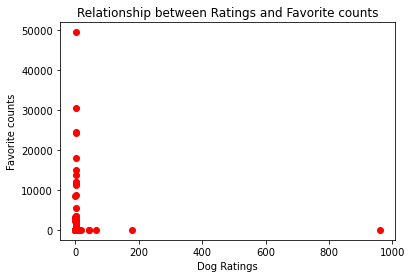

In [82]:
# Relationship between dog_ratings and favorite_count
plt.scatter(tweeter_clean['dog_ratings'],tweeter_clean['favorite_count'],color='red')
plt.title('Relationship between Ratings and Favorite counts')
plt.xlabel('Dog Ratings')
plt.ylabel('Favorite counts');

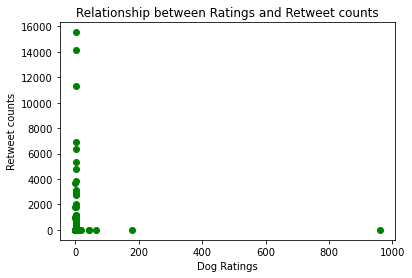

In [83]:
# Relationship between dog_ratings and favorite_count
plt.scatter(tweeter_clean['dog_ratings'],tweeter_clean['retweet_count'],color='green')
plt.title('Relationship between Ratings and Retweet counts')
plt.xlabel('Dog Ratings')
plt.ylabel('Retweet counts');

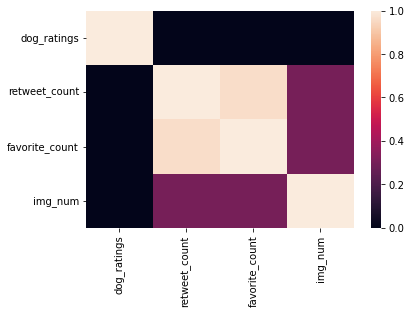

In [84]:
corr = tweeter_clean.corr()
sns.heatmap(corr);

- From the above we can conclude that there is poor correlation between dog ratings and both retweet counts and favorite counts.

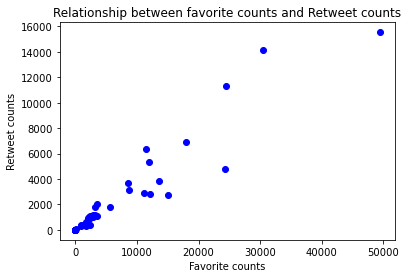

In [85]:
plt.scatter(tweeter_clean['favorite_count'],tweeter_clean['retweet_count'],color='blue')
plt.title('Relationship between favorite counts and Retweet counts')
plt.xlabel('Favorite counts')
plt.ylabel('Retweet counts');

- There is a positive correlation between Favorite counts and retweet counts. This means that the more a person likes a tweet the higher the likelihood for them to retweet it.

In [86]:
# Feature Engineering.
bin_edges =[0.0,1.0,1.1,1.2,960]
bin_names = ['Okay','Slightly Good','Good','Best']
tweeter_clean['Quality_Levels'] = pd.cut(tweeter_clean['dog_ratings'],bin_edges,labels=bin_names)

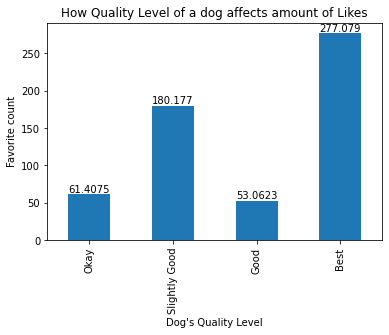

In [87]:
ax = tweeter_clean.groupby('Quality_Levels')['favorite_count'].mean().plot(kind='bar')
plt.title('How Quality Level of a dog affects amount of Likes')
plt.xlabel("Dog's Quality Level")
plt.ylabel('Favorite count')
for container in ax.containers:
    ax.bar_label(container);

- The dogs with the highest quality ratings get more likes.

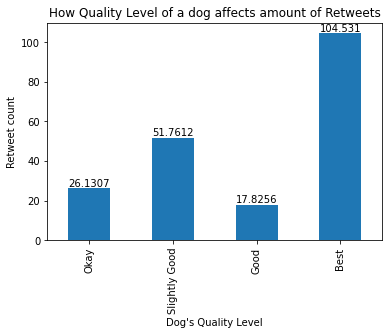

In [88]:
ax = tweeter_clean.groupby('Quality_Levels')['retweet_count'].mean().plot(kind='bar')
plt.title('How Quality Level of a dog affects amount of Retweets')
plt.xlabel("Dog's Quality Level")
plt.ylabel('Retweet count')
for container in ax.containers:
    ax.bar_label(container);

- The higher the dog ratings the more retweets it gets.

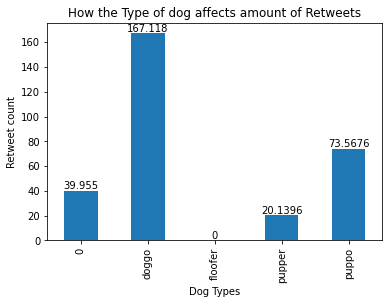

In [89]:
ax = tweeter_clean.groupby('dog_types')['retweet_count'].mean().plot(kind='bar')
plt.title('How the Type of dog affects amount of Retweets')
plt.xlabel("Dog Types")
plt.ylabel('Retweet count')
for container in ax.containers:
    ax.bar_label(container);

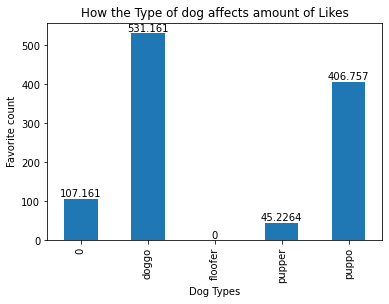

In [90]:
ax = tweeter_clean.groupby('dog_types')['favorite_count'].mean().plot(kind='bar')
plt.title('How the Type of dog affects amount of Likes')
plt.xlabel("Dog Types")
plt.ylabel('Favorite count')
for container in ax.containers:
    ax.bar_label(container);

- The type of dog affects the amount of likes and retweets.

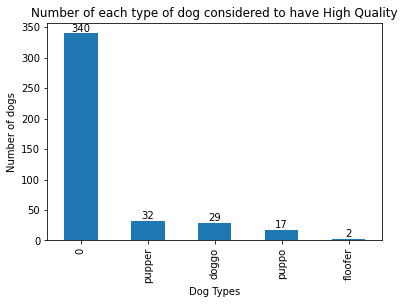

In [91]:
ax=tweeter_clean.query('Quality_Levels == "Best"')['dog_types'].value_counts().plot(kind='bar')
plt.title('Number of each type of dog considered to have High Quality')
plt.xlabel('Dog Types')
plt.ylabel('Number of dogs')
for container in ax.containers:
    ax.bar_label(container);